# KEYRUS Big Data Exercise Analysis

## The big data exercise is finished in four parts:  
### 1, Exploratory Data Analysis  
### 2, Data Preprocessing and Feature Engineering  
### 3, Modeling and Parameter Tuning  
### 4, Prediction and Future Improvement

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
import xgboost as xgb
%matplotlib inline

### 1, Exploratory Data Analysis

In the first part, what we did is some basic data exploration with visualizations to show the pattern of the data with regard to each features and target.

The findings like missing values in Item_Weight and Outlet_Size and column like Item_Fat_Content existing different names for same level of feature will be solved in the second part.

In [2]:
train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')

In [3]:
train.describe

<bound method NDFrame.describe of      Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0              FDA15        9.300          Low Fat         0.016047   
1              DRC01        5.920          Regular         0.019278   
2              FDN15       17.500          Low Fat         0.016760   
3              FDX07       19.200          Regular         0.000000   
4              NCD19        8.930          Low Fat         0.000000   
5              FDP36       10.395          Regular         0.000000   
6              FDO10       13.650          Regular         0.012741   
7              FDP10          NaN          Low Fat         0.127470   
8              FDH17       16.200          Regular         0.016687   
9              FDU28       19.200          Regular         0.094450   
10             FDY07       11.800          Low Fat         0.000000   
11             FDA03       18.500          Regular         0.045464   
12             FDX32       15.100          

In [4]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histogram')

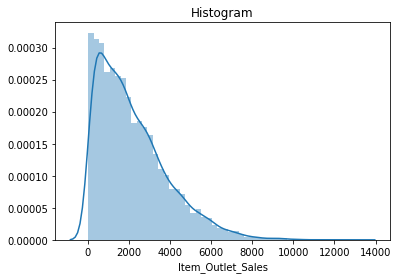

In [6]:
sns.distplot(train['Item_Outlet_Sales'])
plt.title('Histogram')

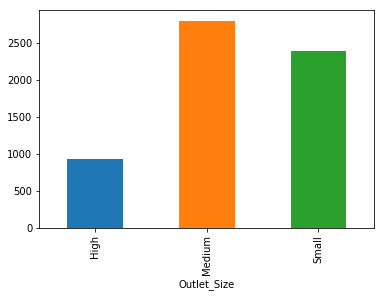

In [7]:
var = train.groupby('Outlet_Size').Item_Outlet_Sales.count()
var.plot(kind='bar') 

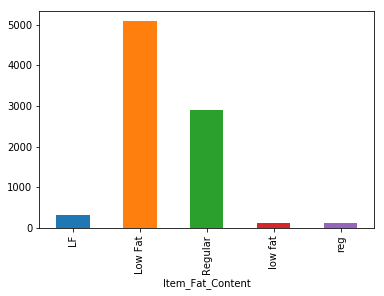

In [8]:
var = train.groupby('Item_Fat_Content').Item_Outlet_Sales.count()
var.plot(kind='bar') 

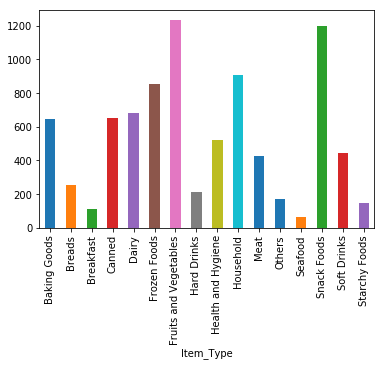

In [9]:
var = train.groupby('Item_Type').Item_Outlet_Sales.count()
var.plot(kind='bar') 

From the chart above, we could see that there are duplicate names for the same level of item fat content. 

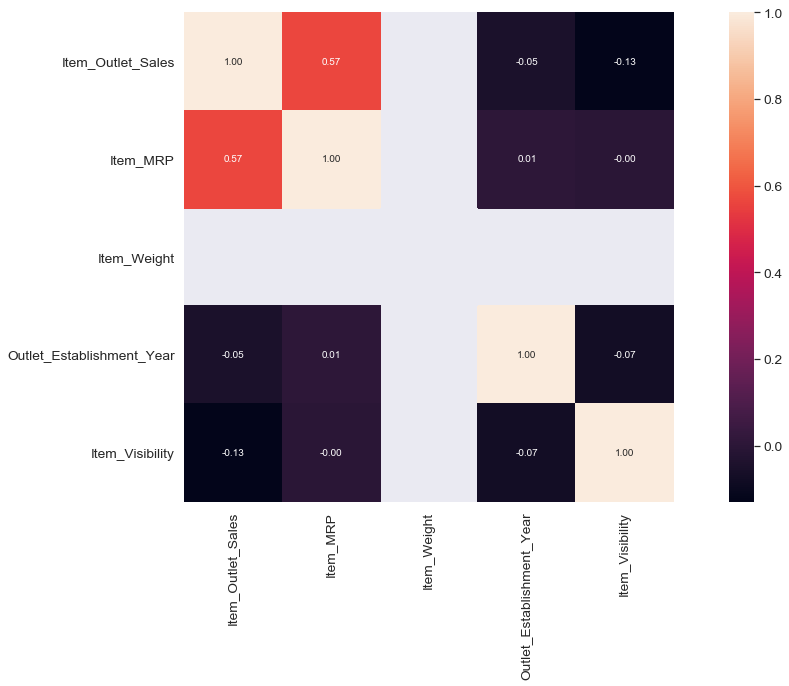

In [10]:
k  = 12
corrmat = train.corr()
cols = corrmat.nlargest(k, 'Item_Outlet_Sales')['Item_Outlet_Sales'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(20, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 2, Data Preprocessing and Feature Engineering 

In this part of the project, we fixed issues like duplicate names for Item_Fat_Content and imputation of missing values in both Item_Weight and Outlet_Size. In addition, we created more features like Good_Location, Selling, Grocery, MRP_level based on the distribution of the features.

In [11]:
train.loc[train['Item_Fat_Content'] == 'Low Fat', 'Item_Fat_Content'] = 'LF'
train.loc[train['Item_Fat_Content'] == 'low fat', 'Item_Fat_Content'] = 'LF'
train.loc[train['Item_Fat_Content'] == 'Regular', 'Item_Fat_Content'] = 'Reg'
train.loc[train['Item_Fat_Content'] == 'reg', 'Item_Fat_Content'] = 'Reg'

In [12]:
test.loc[test['Item_Fat_Content'] == 'Low Fat', 'Item_Fat_Content'] = 'LF'
test.loc[test['Item_Fat_Content'] == 'low fat', 'Item_Fat_Content'] = 'LF'
test.loc[test['Item_Fat_Content'] == 'Regular', 'Item_Fat_Content'] = 'Reg'
test.loc[test['Item_Fat_Content'] == 'reg', 'Item_Fat_Content'] = 'Reg'

In [13]:
train['Item_Fat_Content'].unique()

array(['LF', 'Reg'], dtype=object)

In [14]:
test['Item_Fat_Content'].unique()

array(['LF', 'Reg'], dtype=object)

In [15]:
train['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [16]:
test['Item_Type'].unique()

array(['Snack Foods', 'Dairy', 'Others', 'Fruits and Vegetables',
       'Baking Goods', 'Health and Hygiene', 'Breads', 'Hard Drinks',
       'Seafood', 'Soft Drinks', 'Household', 'Frozen Foods', 'Meat',
       'Canned', 'Starchy Foods', 'Breakfast'], dtype=object)

In [17]:
train.groupby('Item_Type')['Item_Identifier'].describe()

,count,unique,top,freq
Item_Type,,,,
Baking Goods,648,119,FDU12,9
Breads,251,45,FDU23,8
Breakfast,110,20,FDO37,8
Canned,649,120,FDW13,10
Dairy,682,125,FDV38,9
Frozen Foods,856,155,FDF52,9
Fruits and Vegetables,1232,220,FDX31,9
Hard Drinks,214,40,DRN47,9
Health and Hygiene,520,95,NCI29,8


In [18]:
train.groupby('Item_Type')['Item_Identifier'].count()

Item_Type
Baking Goods              648
Breads                    251
Breakfast                 110
Canned                    649
Dairy                     682
Frozen Foods              856
Fruits and Vegetables    1232
Hard Drinks               214
Health and Hygiene        520
Household                 910
Meat                      425
Others                    169
Seafood                    64
Snack Foods              1200
Soft Drinks               445
Starchy Foods             148
Name: Item_Identifier, dtype: int64

In [19]:
set(train.columns.values) - set(test.columns.values) 

{'Item_Outlet_Sales'}

In [20]:
set(train.Item_Type.values) - set(test.Item_Type.values) 

set()

In [21]:
set(train.Item_Identifier.values) - set(test.Item_Identifier.values) 

{'DRE49',
 'FDA04',
 'FDG24',
 'FDG33',
 'FDL10',
 'FDL34',
 'FDO19',
 'FDO52',
 'FDT07',
 'FDU19',
 'FDW13',
 'FDX04',
 'FDX20',
 'NCL31',
 'NCQ06',
 'NCY18'}

Here, we group different item into type groups named Selling based on their mean Item outlet sales data.

In [22]:
train.groupby('Item_Type')['Item_Outlet_Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Item_Type,,,,,,,,
Baking Goods,648.0,1952.971207,1546.788045,37.2848,705.08220,1577.9460,2823.82425,7931.6754
Breads,251.0,2204.132226,1644.235914,35.2874,968.73900,1860.2452,3145.90500,8958.3390
Breakfast,110.0,2111.808651,1911.693586,39.9480,679.11600,1554.6430,2970.30025,8209.3140
Canned,649.0,2225.194904,1645.235638,37.9506,952.09400,1860.2452,3101.29640,10306.5840
Dairy,682.0,2232.542597,1884.404698,40.6138,788.97300,1650.8511,3296.20935,10256.6490
Frozen Foods,856.0,2132.867744,1724.777720,36.6190,808.94700,1687.1372,3079.49145,9678.0688
Fruits and Vegetables,1232.0,2289.009592,1799.503459,45.2744,884.84820,1830.9500,3227.13260,12117.5600
Hard Drinks,214.0,2139.221622,1606.191587,37.9506,834.91320,1816.6353,3071.33540,7843.1240
Health and Hygiene,520.0,2010.000265,1553.633063,34.6216,758.84555,1669.4935,2884.57850,9779.9362


In [23]:
train.loc[train['Item_Type'] == 'Baking Goods', 'Selling'] = 'Low'
train.loc[train['Item_Type'] == 'Others', 'Selling'] = 'Low'
train.loc[train['Item_Type'] == 'Breakfast', 'Selling'] = 'Medium'
train.loc[train['Item_Type'] == 'Frozen Foods', 'Selling'] = 'Medium'
train.loc[train['Item_Type'] == 'Hard Drinks', 'Selling'] = 'Medium'
train.loc[train['Item_Type'] == 'Health and Hygiene', 'Selling'] = 'Medium'
train.loc[train['Item_Type'] == 'Meat', 'Selling'] = 'Medium'
train.loc[train['Item_Type'] == 'Soft Drinks', 'Selling'] = 'Medium'
train.loc[train['Item_Type'] == 'Breads', 'Selling'] = 'High'
train.loc[train['Item_Type'] == 'Canned', 'Selling'] = 'High'
train.loc[train['Item_Type'] == 'Dairy', 'Selling'] = 'High'
train.loc[train['Item_Type'] == 'Fruits and Vegetables', 'Selling'] = 'High'
train.loc[train['Item_Type'] == 'Household', 'Selling'] = 'High'
train.loc[train['Item_Type'] == 'Seafood', 'Selling'] = 'High'
train.loc[train['Item_Type'] == 'Snack Foods', 'Selling'] = 'High'
train.loc[train['Item_Type'] == 'Starchy Foods', 'Selling'] = 'High'

In [24]:
test.loc[test['Item_Type'] == 'Baking Goods', 'Selling'] = 'Low'
test.loc[test['Item_Type'] == 'Others', 'Selling'] = 'Low'
test.loc[test['Item_Type'] == 'Breakfast', 'Selling'] = 'Medium'
test.loc[test['Item_Type'] == 'Frozen Foods', 'Selling'] = 'Medium'
test.loc[test['Item_Type'] == 'Hard Drinks', 'Selling'] = 'Medium'
test.loc[test['Item_Type'] == 'Health and Hygiene', 'Selling'] = 'Medium'
test.loc[test['Item_Type'] == 'Meat', 'Selling'] = 'Medium'
test.loc[test['Item_Type'] == 'Soft Drinks', 'Selling'] = 'Medium'
test.loc[test['Item_Type'] == 'Breads', 'Selling'] = 'High'
test.loc[test['Item_Type'] == 'Canned', 'Selling'] = 'High'
test.loc[test['Item_Type'] == 'Dairy', 'Selling'] = 'High'
test.loc[test['Item_Type'] == 'Fruits and Vegetables', 'Selling'] = 'High'
test.loc[test['Item_Type'] == 'Household', 'Selling'] = 'High'
test.loc[test['Item_Type'] == 'Seafood', 'Selling'] = 'High'
test.loc[test['Item_Type'] == 'Snack Foods', 'Selling'] = 'High'
test.loc[test['Item_Type'] == 'Starchy Foods', 'Selling'] = 'High'

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histogram')

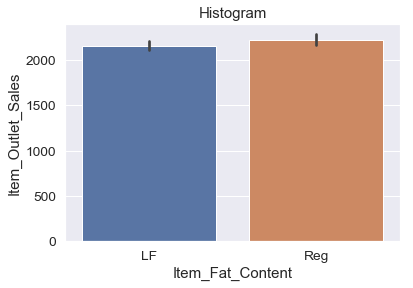

In [25]:
sns.barplot(train['Item_Fat_Content'],train['Item_Outlet_Sales'])
plt.title('Histogram')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025B78C28208>]],
      dtype=object)

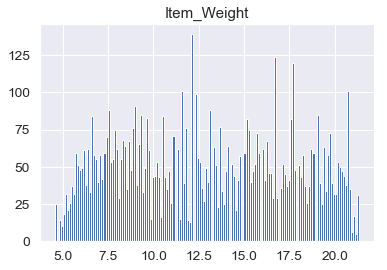

In [26]:
train[['Item_Weight']].hist(bins = 150)

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


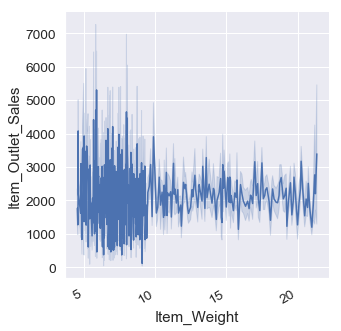

In [27]:
w = sns.relplot(x="Item_Weight", y="Item_Outlet_Sales", kind="line", data=train)
w.fig.autofmt_xdate()

In [28]:
train[train['Item_Weight'] <=10]['Item_Outlet_Sales'].describe()

count    2420.000000
mean     2084.578256
std      1516.454810
min        33.290000
25%       934.783200
50%      1735.740600
75%      2890.237800
max      9779.936200
Name: Item_Outlet_Sales, dtype: float64

In [29]:
train[train['Item_Weight'] >10]['Item_Outlet_Sales'].describe()

count     4640.000000
mean      2136.384889
std       1542.097538
min         36.619000
25%        918.804000
50%       1808.978600
75%       3015.241750
max      10256.649000
Name: Item_Outlet_Sales, dtype: float64

In [30]:
train['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histogram')

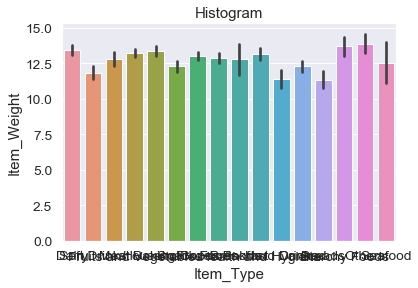

In [31]:
sns.barplot(train['Item_Type'],train['Item_Weight'])
plt.title('Histogram')

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histogram')

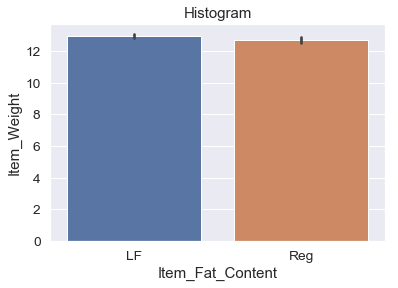

In [32]:
sns.barplot(train['Item_Fat_Content'],train['Item_Weight'])
plt.title('Histogram')

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


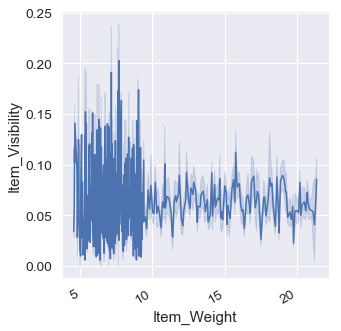

In [33]:
v = sns.relplot(x="Item_Weight", y="Item_Visibility", kind="line", data=train)
v.fig.autofmt_xdate()

In [34]:
train['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

In [35]:
train[train['Item_Weight'] <=10]['Item_Visibility'].describe()

count    2420.000000
mean        0.065173
std         0.049071
min         0.000000
25%         0.028649
50%         0.052191
75%         0.093206
max         0.309390
Name: Item_Visibility, dtype: float64

In [36]:
train[train['Item_Weight'] >10]['Item_Visibility'].describe()

count    4640.000000
mean        0.063333
std         0.048384
min         0.000000
25%         0.026056
50%         0.052534
75%         0.091592
max         0.311090
Name: Item_Visibility, dtype: float64

In [37]:
train['Item_MRP'].describe()

count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


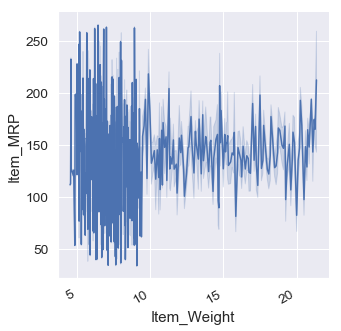

In [38]:
M = sns.relplot(x="Item_Weight", y="Item_MRP", kind="line", data=train)
M.fig.autofmt_xdate()

In [39]:
train[train['Item_Weight'] <=10]['Item_MRP'].describe()

count    2420.000000
mean      139.398355
std        61.801572
min        31.490000
25%        94.167950
50%       135.590300
75%       183.877900
max       266.888400
Name: Item_MRP, dtype: float64

In [40]:
train[train['Item_Weight'] >10]['Item_MRP'].describe()

count    4640.000000
mean      142.201553
std        62.712997
min        31.955800
25%        93.953450
50%       144.328600
75%       187.697700
max       266.888400
Name: Item_MRP, dtype: float64

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histogram')

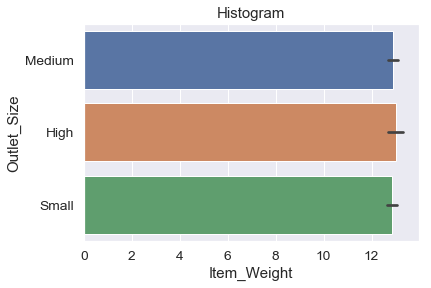

In [41]:
sns.barplot(train['Item_Weight'],train['Outlet_Size'])
plt.title('Histogram')

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


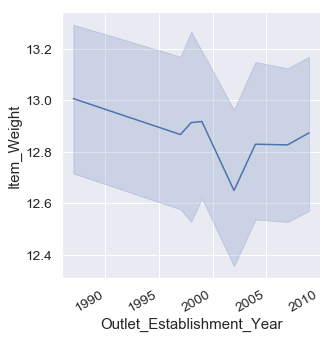

In [42]:
O = sns.relplot(x="Outlet_Establishment_Year", y="Item_Weight", kind="line", data=train)
O.fig.autofmt_xdate()

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histogram')

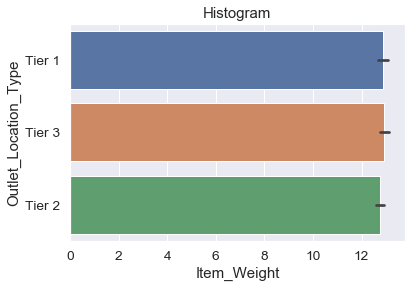

In [43]:
sns.barplot(train['Item_Weight'],train['Outlet_Location_Type'])
plt.title('Histogram')

In [44]:
train.groupby(['Outlet_Identifier','Outlet_Type','Outlet_Size'])['Item_Identifier'].count().reset_index()

,Outlet_Identifier,Outlet_Type,Outlet_Size,Item_Identifier
0,OUT013,Supermarket Type1,High,932
1,OUT018,Supermarket Type2,Medium,928
2,OUT019,Grocery Store,Small,528
3,OUT027,Supermarket Type3,Medium,935
4,OUT035,Supermarket Type1,Small,930
5,OUT046,Supermarket Type1,Small,930
6,OUT049,Supermarket Type1,Medium,930


In [45]:
train.groupby(['Outlet_Identifier','Outlet_Type','Outlet_Size'])['Item_Outlet_Sales'].mean().reset_index()

,Outlet_Identifier,Outlet_Type,Outlet_Size,Item_Outlet_Sales
0,OUT013,Supermarket Type1,High,2298.995256
1,OUT018,Supermarket Type2,Medium,1995.498739
2,OUT019,Grocery Store,Small,340.329723
3,OUT027,Supermarket Type3,Medium,3694.038558
4,OUT035,Supermarket Type1,Small,2438.841866
5,OUT046,Supermarket Type1,Small,2277.844267
6,OUT049,Supermarket Type1,Medium,2348.354635


In [46]:
train.groupby(['Outlet_Identifier','Outlet_Type','Outlet_Location_Type'])['Item_Weight'].mean().reset_index()

,Outlet_Identifier,Outlet_Type,Outlet_Location_Type,Item_Weight
0,OUT010,Grocery Store,Tier 3,12.913153
1,OUT013,Supermarket Type1,Tier 3,13.006148
2,OUT017,Supermarket Type1,Tier 2,12.826668
3,OUT018,Supermarket Type2,Tier 3,12.873346
4,OUT019,Grocery Store,Tier 1,NaN
5,OUT027,Supermarket Type3,Tier 3,NaN
6,OUT035,Supermarket Type1,Tier 2,12.829349
7,OUT045,Supermarket Type1,Tier 2,12.649989
8,OUT046,Supermarket Type1,Tier 1,12.866801
9,OUT049,Supermarket Type1,Tier 1,12.917446


In [47]:
train.groupby('Outlet_Identifier').count().reset_index()

,Outlet_Identifier,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Selling
0,OUT010,555,555,555,555,555,555,555,0,555,555,555,555
1,OUT013,932,932,932,932,932,932,932,932,932,932,932,932
2,OUT017,926,926,926,926,926,926,926,0,926,926,926,926
3,OUT018,928,928,928,928,928,928,928,928,928,928,928,928
4,OUT019,528,0,528,528,528,528,528,528,528,528,528,528
5,OUT027,935,0,935,935,935,935,935,935,935,935,935,935
6,OUT035,930,930,930,930,930,930,930,930,930,930,930,930
7,OUT045,929,929,929,929,929,929,929,0,929,929,929,929
8,OUT046,930,930,930,930,930,930,930,930,930,930,930,930
9,OUT049,930,930,930,930,930,930,930,930,930,930,930,930


Based on the findings so far, there is a reason to believe that the Item weight is not missing at random so we could impute the missing values with the random choice from the same column with the same condition. 

In [48]:
train.loc[train.loc[:,'Outlet_Identifier'] =='OUT019','Item_Weight']=train.loc[train.loc[:,'Outlet_Identifier'] =='OUT019','Item_Weight'].apply(lambda x: np.random.choice(train.loc[train.loc[:,'Outlet_Type'] =='Grocery Store','Item_Weight'].dropna()))

In [50]:
train.loc[train.loc[:,'Outlet_Identifier'] =='OUT027','Item_Weight']=train.loc[train.loc[:,'Outlet_Identifier'] =='OUT027','Item_Weight'].apply(lambda x: np.random.choice(train.loc[train.loc[:,'Outlet_Type'] !='Grocery Store','Item_Weight'].dropna()))

In [52]:
test.groupby('Outlet_Identifier').count().reset_index()

,Outlet_Identifier,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Selling
0,OUT010,370,370,370,370,370,370,370,0,370,370,370
1,OUT013,621,621,621,621,621,621,621,621,621,621,621
2,OUT017,617,617,617,617,617,617,617,0,617,617,617
3,OUT018,618,618,618,618,618,618,618,618,618,618,618
4,OUT019,352,0,352,352,352,352,352,352,352,352,352
5,OUT027,624,0,624,624,624,624,624,624,624,624,624
6,OUT035,620,620,620,620,620,620,620,620,620,620,620
7,OUT045,619,619,619,619,619,619,619,0,619,619,619
8,OUT046,620,620,620,620,620,620,620,620,620,620,620
9,OUT049,620,620,620,620,620,620,620,620,620,620,620


In [54]:
test.loc[test.loc[:,'Outlet_Identifier'] =='OUT019','Item_Weight']=test.loc[test.loc[:,'Outlet_Identifier'] =='OUT019','Item_Weight'].apply(lambda x: np.random.choice(test.loc[test.loc[:,'Outlet_Type'] =='Grocery Store','Item_Weight'].dropna()))

In [55]:
test.loc[test.loc[:,'Outlet_Identifier'] =='OUT027','Item_Weight']=test.loc[test.loc[:,'Outlet_Identifier'] =='OUT027','Item_Weight'].apply(lambda x: np.random.choice(test.loc[test.loc[:,'Outlet_Type'] !='Grocery Store','Item_Weight'].dropna()))

To detect the affect might caused by the item weight in integer part and decimal part, we created two new features here.

In [57]:
train['Item_Weight_Decimal'] = train['Item_Weight'].astype(str).str.split('.').str[1].astype(int)

In [58]:
train['Item_Weight_Integer'] = train['Item_Weight'].astype(str).str.split('.').str[0].astype(int)

In [59]:
test['Item_Weight_Decimal'] = test['Item_Weight'].astype(str).str.split('.').str[1].astype(int)

In [60]:
test['Item_Weight_Integer'] = test['Item_Weight'].astype(str).str.split('.').str[0].astype(int)

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


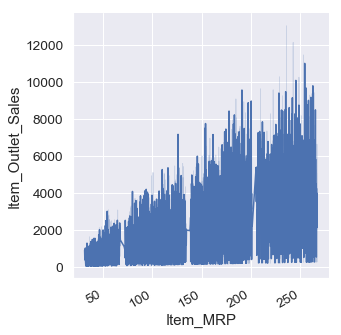

In [61]:
P = sns.relplot(x="Item_MRP", y="Item_Outlet_Sales", kind="line", data=train)
P.fig.autofmt_xdate()

In [62]:
train['Item_MRP'].describe()

count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

In [63]:
train[train['Item_MRP'] <=75]['Item_Outlet_Sales'].describe()

count    1395.000000
mean      749.420185
std       504.781150
min        33.290000
25%       383.500800
50%       695.095200
75%      1013.680500
max      3112.615000
Name: Item_Outlet_Sales, dtype: float64

In [64]:
train[(train['Item_MRP'] <=140) & (train['Item_MRP'] > 75)]['Item_Outlet_Sales'].describe()

count    2724.000000
mean     1632.054715
std      1009.966855
min        75.901200
25%       900.827400
50%      1537.998000
75%      2220.443000
max      7158.681600
Name: Item_Outlet_Sales, dtype: float64

In [65]:
train[(train['Item_MRP'] <=200) & (train['Item_MRP'] > 140)]['Item_Outlet_Sales'].describe()

count    2964.000000
mean     2632.411243
std      1609.251370
min       139.818000
25%      1471.085100
50%      2553.010100
75%      3595.320000
max      9554.230000
Name: Item_Outlet_Sales, dtype: float64

In [66]:
train[train['Item_MRP'] > 200]['Item_Outlet_Sales'].describe()

count     1440.000000
mean      3678.819642
std       2124.823458
min        207.063800
25%       2096.271300
50%       3587.663300
75%       5103.357000
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

Based on the findings of influence between different MRP level and Item sales, a new feature was generated here. 

In [67]:
train.loc[train['Item_MRP'] <=75, 'MRP_level'] = 'low'
train.loc[(train['Item_MRP'] <=140) & (train['Item_MRP'] > 75), 'MRP_level'] = 'medium'
train.loc[(train['Item_MRP'] <=200) & (train['Item_MRP'] > 140), 'MRP_level'] = 'high'
train.loc[train['Item_MRP'] > 200, 'MRP_level'] = 'extreme'

In [68]:
test.loc[test['Item_MRP'] <=75, 'MRP_level'] = 'low'
test.loc[(test['Item_MRP'] <=140) & (test['Item_MRP'] > 75), 'MRP_level'] = 'medium'
test.loc[(test['Item_MRP'] <=200) & (test['Item_MRP'] > 140), 'MRP_level'] = 'high'
test.loc[test['Item_MRP'] > 200, 'MRP_level'] = 'extreme'

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


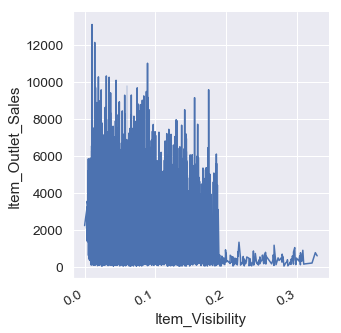

In [69]:
I = sns.relplot(x="Item_Visibility", y="Item_Outlet_Sales", kind="line", data=train)
I.fig.autofmt_xdate()

In [70]:
train[train['Item_Visibility'] <=0.19]['Item_Outlet_Sales'].describe()

count     8363.000000
mean      2216.664348
std       1702.985178
min         33.290000
25%        882.185000
50%       1833.613200
75%       3129.260000
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

In [71]:
train[train['Item_Visibility'] >0.19]['Item_Outlet_Sales'].describe()

count     160.000000
mean      332.259168
std       233.218847
min        35.287400
25%       162.288750
50%       269.316100
75%       456.738800
max      1324.942000
Name: Item_Outlet_Sales, dtype: float64

In [72]:
train['Item_Visibility'] = winsorize(train['Item_Visibility'], limits = 0.19)

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


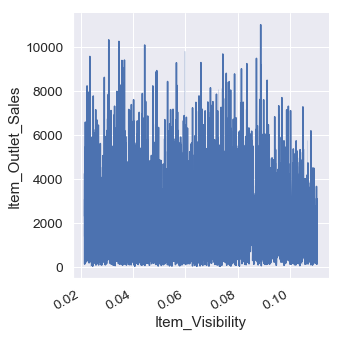

In [73]:
I1 = sns.relplot(x="Item_Visibility", y="Item_Outlet_Sales", kind="line", data=train)
I1.fig.autofmt_xdate()

There are some outliers in the item visibility feature, we implemented winsorize technique here to reduce the affect of outliers on our prediction.

In [74]:
test[test['Item_Visibility']>0.19].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Weight_Decimal,Item_Weight_Integer
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,12.765263,0.243062,134.554689,1991.614035,150.236842,12.263158
std,4.698950,0.034482,63.536926,6.527693,260.060350,4.733710
min,5.035000,0.192767,34.187400,1985.000000,0.000000,5.000000
25%,8.476250,0.214983,89.267850,1985.000000,5.000000,8.000000
50%,12.725000,0.237160,123.240100,1998.000000,35.500000,12.000000
75%,17.150000,0.267740,177.883750,1998.000000,89.000000,17.000000
max,20.850000,0.323637,265.088400,1998.000000,905.000000,20.000000


In [75]:
test['Item_Visibility'] = winsorize(test['Item_Visibility'], limits = 0.19)

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histogram')

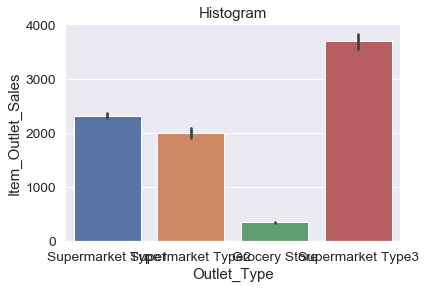

In [76]:
sns.barplot(train['Outlet_Type'],train['Item_Outlet_Sales'])
plt.title('Histogram')

Since there is a clear difference between grocery store and supermarket, a new feature to represent this effect is needed.

In [77]:
train.loc[train['Outlet_Type'] == 'Grocery Store', 'Grocery_Store'] = 'Yes'
train.loc[train['Outlet_Type'] != 'Grocery Store', 'Grocery_Store'] = 'No'

In [78]:
test.loc[test['Outlet_Type'] == 'Grocery Store', 'Grocery_Store'] = 'Yes'
test.loc[test['Outlet_Type'] != 'Grocery Store', 'Grocery_Store'] = 'No'

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histogram')

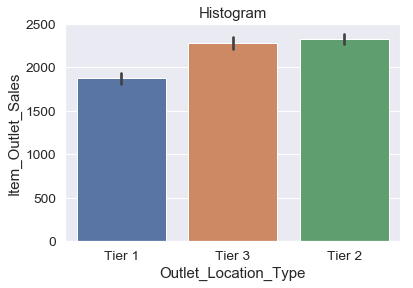

In [79]:
sns.barplot(train['Outlet_Location_Type'],train['Item_Outlet_Sales'])
plt.title('Histogram')

Good location feature was generated to represent the difference between Tier1 and Tier2 and 3.

In [80]:
train.loc[train['Outlet_Location_Type'] == 'Tier1', 'Good_Location'] = 'No'
train.loc[train['Outlet_Location_Type'] != 'Tier1', 'Good_Location'] = 'Yes'

In [81]:
test.loc[test['Outlet_Location_Type'] == 'Tier1', 'Good_Location'] = 'No'
test.loc[test['Outlet_Location_Type'] != 'Tier1', 'Good_Location'] = 'Yes'

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histogram')

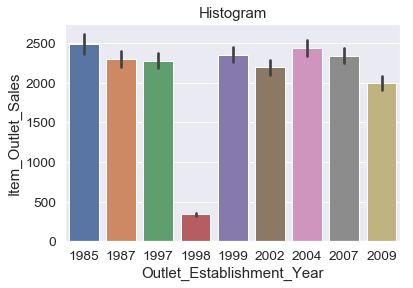

In [82]:
sns.barplot(train['Outlet_Establishment_Year'],train['Item_Outlet_Sales'])
plt.title('Histogram')

In [83]:
train[train['Outlet_Establishment_Year'] ==1998]['Item_Outlet_Sales'].describe()

count     555.000000
mean      339.351662
std       271.014855
min        33.290000
25%       154.132700
50%       250.340800
75%       455.407200
max      1775.688600
Name: Item_Outlet_Sales, dtype: float64

In [84]:
train[train['Outlet_Establishment_Year'] ==1999]['Item_Outlet_Sales'].describe()

count     930.000000
mean     2348.354635
std      1513.289464
min       111.854400
25%      1182.793700
50%      1966.107400
75%      3281.728200
max      7646.047200
Name: Item_Outlet_Sales, dtype: float64

Missing values in the Outlet size column is not missing at random, there is a relationship between outlet identifier and the missing outlet size. We impute those missing values based on the outlet identifier.

In [86]:
train.groupby(['Outlet_Identifier','Outlet_Type','Outlet_Location_Type'])['Item_Weight'].mean().reset_index()

,Outlet_Identifier,Outlet_Type,Outlet_Location_Type,Item_Weight
0,OUT010,Grocery Store,Tier 3,12.913153
1,OUT013,Supermarket Type1,Tier 3,13.006148
2,OUT017,Supermarket Type1,Tier 2,12.826668
3,OUT018,Supermarket Type2,Tier 3,12.873346
4,OUT019,Grocery Store,Tier 1,12.736667
5,OUT027,Supermarket Type3,Tier 3,12.769984
6,OUT035,Supermarket Type1,Tier 2,12.829349
7,OUT045,Supermarket Type1,Tier 2,12.649989
8,OUT046,Supermarket Type1,Tier 1,12.866801
9,OUT049,Supermarket Type1,Tier 1,12.917446


In [87]:
train.groupby('Outlet_Identifier').count().reset_index()

,Outlet_Identifier,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Selling,Item_Weight_Decimal,Item_Weight_Integer,MRP_level,Grocery_Store,Good_Location
0,OUT010,555,555,555,555,555,555,555,0,555,555,555,555,555,555,555,555,555
1,OUT013,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932
2,OUT017,926,926,926,926,926,926,926,0,926,926,926,926,926,926,926,926,926
3,OUT018,928,928,928,928,928,928,928,928,928,928,928,928,928,928,928,928,928
4,OUT019,528,528,528,528,528,528,528,528,528,528,528,528,528,528,528,528,528
5,OUT027,935,935,935,935,935,935,935,935,935,935,935,935,935,935,935,935,935
6,OUT035,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930
7,OUT045,929,929,929,929,929,929,929,0,929,929,929,929,929,929,929,929,929
8,OUT046,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930
9,OUT049,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930


In [91]:
train.groupby('Outlet_Identifier').Item_Outlet_Sales.describe().reset_index()

,Outlet_Identifier,count,mean,std,min,25%,50%,75%,max
0,OUT010,555.0,339.351662,271.014855,33.2900,154.13270,250.3408,455.40720,1775.6886
1,OUT013,932.0,2298.995256,1533.531664,73.2380,1072.60380,2050.6640,3166.37835,10256.6490
2,OUT017,926.0,2340.675263,1550.778025,143.8128,1195.94325,2005.0567,3096.46935,9664.7528
3,OUT018,928.0,1995.498739,1375.932889,69.2432,981.55565,1655.1788,2702.64865,6768.5228
4,OUT019,528.0,340.329723,249.979449,33.9558,153.63335,265.3213,460.73360,1482.0708
5,OUT027,935.0,3694.038558,2127.760054,241.6854,2044.33890,3364.9532,4975.52340,13086.9648
6,OUT035,930.0,2438.841866,1538.512533,113.8518,1238.88735,2109.2544,3310.35760,8479.6288
7,OUT045,929.0,2192.384798,1462.399658,99.8700,1068.60900,1834.9448,2929.52000,8994.9580
8,OUT046,930.0,2277.844267,1488.405631,101.8674,1137.18640,1945.8005,3095.63710,9779.9362
9,OUT049,930.0,2348.354635,1513.289464,111.8544,1182.79370,1966.1074,3281.72820,7646.0472


In [88]:
for index, row in train.iterrows():
    if train.loc[index,'Outlet_Identifier'] == 'OUT010':
        train.loc[index, 'Outlet_Size']='Small'

In [89]:
for index, row in test.iterrows():
    if test.loc[index,'Outlet_Identifier'] == 'OUT010':
        test.loc[index, 'Outlet_Size']='Small'

In [92]:
for index, row in train.iterrows():
    if train.loc[index,'Outlet_Identifier'] == 'OUT017':
        train.loc[index, 'Outlet_Size']='High'

In [93]:
for index, row in test.iterrows():
    if test.loc[index,'Outlet_Identifier'] == 'OUT017':
        test.loc[index, 'Outlet_Size']='High'

In [94]:
for index, row in train.iterrows():
    if train.loc[index,'Outlet_Identifier'] == 'OUT045':
        train.loc[index, 'Outlet_Size']='Medium'

In [95]:
for index, row in test.iterrows():
    if test.loc[index,'Outlet_Identifier'] == 'OUT045':
        test.loc[index, 'Outlet_Size']='Medium'

In [96]:
train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Selling                      0
Item_Weight_Decimal          0
Item_Weight_Integer          0
MRP_level                    0
Grocery_Store                0
Good_Location                0
dtype: int64

In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 18 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8523 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  8523 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
Selling                      8523 non-null object
Item_Weight_Decimal          8523 non-null int32
Item_Weight_Integer          8523 non-null int32
MRP_level                    8523 non-null object
Grocery_Store                8523 non-null object
Good_Location                8523 non-null

In [99]:
test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Selling                      0
Item_Weight_Decimal          0
Item_Weight_Integer          0
MRP_level                    0
Grocery_Store                0
Good_Location                0
dtype: int64

In [100]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 17 columns):
Item_Identifier              5681 non-null object
Item_Weight                  5681 non-null float64
Item_Fat_Content             5681 non-null object
Item_Visibility              5681 non-null float64
Item_Type                    5681 non-null object
Item_MRP                     5681 non-null float64
Outlet_Identifier            5681 non-null object
Outlet_Establishment_Year    5681 non-null int64
Outlet_Size                  5681 non-null object
Outlet_Location_Type         5681 non-null object
Outlet_Type                  5681 non-null object
Selling                      5681 non-null object
Item_Weight_Decimal          5681 non-null int32
Item_Weight_Integer          5681 non-null int32
MRP_level                    5681 non-null object
Grocery_Store                5681 non-null object
Good_Location                5681 non-null object
dtypes: float64(3), int32(2), int64(1), obj

The second part is finished by now, the data looks good and we will continue to the third part.

### 3, Modeling and Parameter Tuning  

In [102]:
train_new = train[['Item_Identifier','Item_Weight','Item_Fat_Content','Item_Visibility','Item_Type','Item_MRP','Outlet_Identifier','Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type','Outlet_Type','Selling','Item_Weight_Decimal','Item_Weight_Integer','MRP_level','Grocery_Store','Good_Location','Item_Outlet_Sales']]
train_new.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Selling,Item_Weight_Decimal,Item_Weight_Integer,MRP_level,Grocery_Store,Good_Location,Item_Outlet_Sales
0,FDA15,9.30,LF,0.021453,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,High,3,9,extreme,No,Yes,3735.1380
1,DRC01,5.92,Reg,0.021453,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,Medium,92,5,low,No,Yes,443.4228
2,FDN15,17.50,LF,0.021453,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,Medium,5,17,high,No,Yes,2097.2700
3,FDX07,19.20,Reg,0.021453,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,High,2,19,high,Yes,Yes,732.3800
4,NCD19,8.93,LF,0.021453,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,High,93,8,low,No,Yes,994.7052


In [103]:
test_new = test[['Item_Identifier','Item_Weight','Item_Fat_Content','Item_Visibility','Item_Type','Item_MRP','Outlet_Identifier','Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type','Outlet_Type','Selling','Item_Weight_Decimal','Item_Weight_Integer','MRP_level','Grocery_Store','Good_Location']]
test_new.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Selling,Item_Weight_Decimal,Item_Weight_Integer,MRP_level,Grocery_Store,Good_Location
0,FDW58,20.750,LF,0.021959,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,High,75,20,medium,No,Yes
1,FDW14,8.300,Reg,0.038428,Dairy,87.3198,OUT017,2007,High,Tier 2,Supermarket Type1,High,3,8,medium,No,Yes
2,NCN55,14.600,LF,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,Low,6,14,extreme,Yes,Yes
3,FDQ58,7.315,LF,0.021959,Snack Foods,155.0340,OUT017,2007,High,Tier 2,Supermarket Type1,High,315,7,high,No,Yes
4,FDY38,7.785,Reg,0.106916,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,High,785,7,extreme,No,Yes


In [104]:
train_x=train_new.iloc[:,0:17]
train_y=train_new.iloc[:,-1]

In [105]:
list(train_x.columns.values)

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Selling',
 'Item_Weight_Decimal',
 'Item_Weight_Integer',
 'MRP_level',
 'Grocery_Store',
 'Good_Location']

In [106]:
train_y

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
5        556.6088
6        343.5528
7       4022.7636
8       1076.5986
9       4710.5350
10      1516.0266
11      2187.1530
12      1589.2646
13      2145.2076
14      1977.4260
15      1547.3192
16      1621.8888
17       718.3982
18      2303.6680
19      2748.4224
20      3775.0860
21      4064.0432
22      1587.2672
23       214.3876
24      4078.0250
25       838.9080
26      1065.2800
27       308.9312
28       178.4344
29       125.8362
          ...    
8493    4727.1800
8494    1637.8680
8495    4314.3840
8496    3715.1640
8497    2247.0750
8498    1601.2490
8499    2976.1260
8500    1907.5170
8501    1508.0370
8502    3020.0688
8503    3392.9168
8504    4138.6128
8505    2117.2440
8506    3944.8650
8507     515.9950
8508    2587.9646
8509     424.7804
8510    7182.6504
8511    4207.8560
8512    2479.4392
8513     595.2252
8514     468.7232
8515    1571.2880
8516     858.8820
8517    36

In [107]:
set(train_x.columns.values) - set(test.columns.values) 

set()

In [108]:
train_x=train_x.drop(train_x.columns[~train_x.columns.isin(test.columns)], 1)

In [109]:
set(train_x.columns.values) - set(test.columns.values) 

set()

We will try H2O AutoML to test our data.

In [110]:
train1, valid = train_test_split(train_new, test_size=0.3, random_state=123)

In [111]:
import h2o
import math
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from C:\Users\johnn\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\johnn\AppData\Local\Temp\tmp41fs4k3m
  JVM stdout: C:\Users\johnn\AppData\Local\Temp\tmp41fs4k3m\h2o_johnn_started_from_python.out
  JVM stderr: C:\Users\johnn\AppData\Local\Temp\tmp41fs4k3m\h2o_johnn_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.4
H2O cluster version age:,1 year and 24 days !!!
H2O cluster name:,H2O_from_python_johnn_cfljdd
H2O cluster total nodes:,1
H2O cluster free memory:,3.547 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [112]:
trainh = h2o.H2OFrame(train1)
validh = h2o.H2OFrame(valid)
testh  = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [113]:
y = 'Item_Outlet_Sales'
X = [name for name in trainh.columns if name not in [y,'Item_Identifier']]

In [114]:
# define random grid search parameters
hyper_parameters = {'ntrees':list(range(1, 100, 5)),
                    'categorical_encoding':['sort_by_response','label_encoder','one_hot_explicit'],
                    'learn_rate':[s/float(10) for s in range(1, 11)],
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'max_depth':list(range(1, 50, 2)),
                    'stopping_rounds':list(range(0,30,5)),
                    'stopping_tolerance':[s/float(10) for s in range(0, 10)],
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':50,
                   'max_runtime_secs':600}

# initialize grid search
gsearch_nobalance = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch_nobalance.train(
    x=X,
    y=y,
    training_frame=trainh,
    validation_frame=validh)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [115]:
gbm_model = gsearch_nobalance.get_grid()[0]

In [116]:
gbm_model.actual_params

{'balance_classes': False,
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'SortByResponse',
 'checkpoint': None,
 'class_sampling_factors': None,
 'col_sample_rate': 0.7,
 'col_sample_rate_change_per_level': 1.0,
 'col_sample_rate_per_tree': 1.0,
 'custom_metric_func': None,
 'distribution': 'gaussian',
 'fold_assignment': 'AUTO',
 'fold_column': None,
 'histogram_type': 'AUTO',
 'huber_alpha': 0.9,
 'ignore_const_cols': True,
 'ignored_columns': ['Item_Identifier'],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_predictions': False,
 'learn_rate': 0.2,
 'learn_rate_annealing': 1.0,
 'max_abs_leafnode_pred': 1.7976931348623157e+308,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_depth': 3,
 'max_hit_ratio_k': 0,
 'max_runtime_secs': 589.0,
 'min_rows': 10.0,
 'min_split_improvement': 1e-05,
 'model_id': 'Grid_GBM_Key_Frame__upload_8220057db463c77946adb548e25f4456.hex_model

In [117]:
gbm_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_Key_Frame__upload_8220057db463c77946adb548e25f4456.hex_model_python_1554173497103_1_model_17


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1139937.6750498079
RMSE: 1067.67863847218
MAE: 755.5759640139619
RMSLE: NaN
Mean Residual Deviance: 1139937.6750498079

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 1202245.6276369942
RMSE: 1096.4696200246472
MAE: 780.7758883469972
RMSLE: NaN
Mean Residual Deviance: 1202245.6276369942
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-04-01 22:51:54,10.931 sec,0.0,1692.6217546,1338.0218590,2864968.4040507,1738.1821417,1361.9618145,3021277.1578488
,2019-04-01 22:51:54,10.935 sec,1.0,1524.5457061,1193.8569165,2324239.6098964,1562.2940577,1214.1282659,2440762.7228052
,2019-04-01 22:51:54,10.938 sec,2.0,1399.3546005,1085.3445625,1958193.2979964,1428.2480704,1100.7006991,2039892.5505084
,2019-04-01 22:51:54,10.941 sec,3.0,1316.7953954,1006.7280096,1733950.1133145,1345.1249139,1021.7534834,1809361.0339157
,2019-04-01 22:51:54,10.943 sec,4.0,1252.0782695,945.8325871,1567699.9928885,1278.1118356,959.1798687,1633569.8644224
---,---,---,---,---,---,---,---,---,---
,2019-04-01 22:51:54,10.990 sec,22.0,1070.1320848,752.9275763,1145182.6788392,1094.8656863,774.1398383,1198730.8709373
,2019-04-01 22:51:54,10.993 sec,23.0,1070.3520692,752.6809670,1145653.5521025,1094.8948698,773.6991366,1198794.7759080
,2019-04-01 22:51:54,10.996 sec,24.0,1070.6061092,754.6416525,1146197.4410435,1095.5747251,776.3252857,1200283.9782641
,2019-04-01 22:51:54,10.998 sec,25.0,1070.0960365,755.5869093,1145105.5272339,1093.2184099,775.9740283,1195126.4917391



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Item_MRP,6012376064.0000000,1.0,0.4181017
Outlet_Identifier,4476334592.0000000,0.7445201,0.3112851
MRP_level,2325615360.0000000,0.3868047,0.1617237
Outlet_Type,564096768.0000000,0.0938226,0.0392274
Item_Type,426852128.0000000,0.0709956,0.0296834
Grocery_Store,255009728.0000000,0.0424141,0.0177334
Outlet_Establishment_Year,199708832.0000000,0.0332163,0.0138878
Item_Visibility,47422640.0000000,0.0078875,0.0032978
Outlet_Size,25787570.0000000,0.0042891,0.0017933
Item_Weight,24995906.0000000,0.0041574,0.0017382


In [118]:
print(gbm_model.model_performance(test_data=validh).r2())

0.6019806079491714


In [119]:
print(gbm_model.model_performance(test_data=trainh).r2())

0.6021116068857052


In [135]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from __future__ import print_function
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,16 mins 09 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.4
H2O cluster version age:,1 year and 24 days !!!
H2O cluster name:,H2O_from_python_johnn_cfljdd
H2O cluster total nodes:,1
H2O cluster free memory:,3.300 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [136]:
trainh = h2o.H2OFrame(train1)
validh = h2o.H2OFrame(valid)
testh  = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [140]:
y = 'Item_Outlet_Sales'
x = [name for name in trainh.columns if name not in [y,'Item_Identifier']]

In [138]:
nfolds = 5

In [143]:
my_gbm = H2OGradientBoostingEstimator(distribution="gaussian",
                                      ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x=x, y=y, training_frame=trainh)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [144]:
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x=x, y=y, training_frame=trainh)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [145]:
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gaussian",
                                       base_models=[my_gbm, my_rf])
ensemble.train(x=x, y=y, training_frame=trainh)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [148]:
# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(validh)

# Compare to base learner performance on the test set
perf_gbm_test = my_gbm.model_performance(validh)
perf_rf_test = my_rf.model_performance(validh)
baselearner_best_r2_test = max(perf_gbm_test.r2(), perf_rf_test.r2())
stack_r2_test = perf_stack_test.r2()
print("Best Base-learner Test r2:  {0}".format(baselearner_best_r2_test))
print("Ensemble Test r2:  {0}".format(stack_r2_test))

# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(validh)

Best Base-learner Test r2:  0.594347570373612
Ensemble Test r2:  0.5023998677084871
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [150]:
# Specify GBM hyperparameters for the grid
hyper_params = {"learn_rate": [0.01, 0.03],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
search_criteria = {"strategy": "RandomDiscrete", "max_models": 3, "seed": 1}

# Train the grid
grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid_gaussian")
grid.train(x=x, y=y, training_frame=trainh)

# Train a stacked ensemble using the GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm_grid_gaussian",
                                       base_models=grid.model_ids)
ensemble.train(x=x, y=y, training_frame=trainh)

# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(validh)

# Compare to base learner performance on the test set
baselearner_best_r2_test = max([h2o.get_model(model).model_performance(test_data=validh).r2() for model in grid.model_ids])
stack_r2_test = perf_stack_test.r2()
print("Best Base-learner Test r2:  {0}".format(baselearner_best_r2_test))
print("Ensemble Test r2:  {0}".format(stack_r2_test))

# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(validh)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%
Best Base-learner Test r2:  0.2308605230437507
Ensemble Test r2:  0.5322748702153011
stackedensemble prediction progress: |████████████████████████████████████| 100%


The performance from H2O is presented above and here are more models tested to optimize the prediction result.

First of all, we take the cubic root of target variable to normalize the result.

In [120]:
train_y1 = np.cbrt(train_y)

C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histogram')

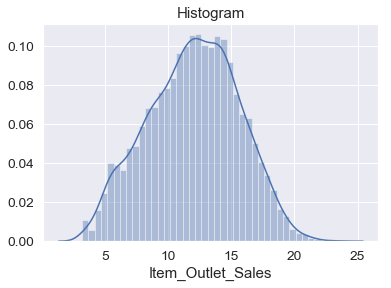

In [121]:
sns.distplot(train_y1)
plt.title('Histogram')

Feature encoding for the categorical variables in our trainning dataset.

In [123]:
encoder = ce.TargetEncoder()

In [124]:
train_x = encoder.fit_transform(train_x.values, train_y1)

In [160]:
test = encoder.transform(test.values)

We will run three models separately and observe the performance with parameter tuning.

In [125]:
model = ElasticNet()
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('model', model)])
param_distributions= dict(model__alpha = [0.1,0.2,0.5,0.6,0.7],
                         model__fit_intercept=[True,False],
                         model__l1_ratio=[0.1,0.2,0.5,0.6,0.7],
                         model__warm_start=[False,True],
                         model__copy_X=[False,True])
bestmodel = RandomizedSearchCV(pipe,param_distributions=param_distributions,cv=5,n_jobs=1,random_state=1,scoring='r2')
bestmodel.fit(train_x, train_y1)
bestmodel.cv_results_

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

{'mean_fit_time': array([0.01715341, 0.01655664, 0.01894836, 0.01176662, 0.01156836,
        0.01336374, 0.01455994, 0.02094326, 0.02772551, 0.01336336]),
 'mean_score_time': array([0.00279412, 0.00278978, 0.00259361, 0.00259395, 0.00239449,
        0.00279369, 0.00299292, 0.00299234, 0.00299253, 0.00279369]),
 'mean_test_score': array([-3.75601492,  0.72061577, -3.74109339,  0.70147176,  0.67547362,
        -4.06368528, -4.0639016 ,  0.72675881,  0.72733568,  0.66744236]),
 'mean_train_score': array([-3.81104788,  0.72148284, -3.79404973,  0.70196913,  0.67585206,
        -4.12410438, -4.12026003,  0.72739869,  0.72797534,  0.66784595]),
 'param_model__alpha': masked_array(data=[0.2, 0.2, 0.1, 0.5, 0.7, 0.7, 0.5, 0.1, 0.1, 0.7],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_model__copy_X': masked_array(data=[False, False, True, True, True, True, False, False,
  

In [126]:
bestmodel.best_score_

0.7273356801281996

In [128]:
model1 = RandomForestRegressor()
scaler = StandardScaler()
pipe1 = Pipeline([('scaler', scaler), ('model', model1)])
param_distributions= dict(
                         model__n_estimators = [10,20,40,80,100],
                         model__max_depth=[2,4,6,8],
                         model__min_samples_leaf=[1,2,3,4],
                         model__min_samples_split=[2,4,6,8],
                         model__warm_start=[False,True])
bestmodel1 = RandomizedSearchCV(pipe1,param_distributions=param_distributions,cv=5,n_jobs=1,random_state=1,scoring='r2')
bestmodel1.fit(train_x, train_y)
bestmodel1.cv_results_

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

{'mean_fit_time': array([0.10633626, 0.34208488, 0.64608779, 0.88484411, 0.10591049,
        0.5140306 , 1.23670378, 0.17732954, 1.28915753, 0.13305817]),
 'mean_score_time': array([0.00436735, 0.00678215, 0.00975842, 0.01455112, 0.00458941,
        0.00877123, 0.01714272, 0.00478411, 0.01973181, 0.00397043]),
 'mean_test_score': array([0.47780373, 0.63002259, 0.63155735, 0.61544513, 0.48082578,
        0.63807685, 0.63883765, 0.62571181, 0.63165173, 0.638779  ]),
 'mean_train_score': array([0.48346688, 0.70188079, 0.70714713, 0.62621399, 0.48550127,
        0.66752974, 0.66727523, 0.70018511, 0.70401888, 0.66537794]),
 'param_model__max_depth': masked_array(data=[2, 8, 8, 4, 2, 6, 6, 8, 8, 6],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_model__min_samples_leaf': masked_array(data=[4, 4, 2, 4, 3, 3, 4, 4, 4, 2],
              mask=[False, False, False, False, F

In [129]:
bestmodel1.best_score_

0.6388376505386851

In [153]:
reg = xgb.XGBRegressor()
scaler = StandardScaler()
pipe3 = Pipeline([('scaler', scaler), ('model', reg)])
param_distributions= dict(
                         model__max_depth = [3,4,5],
                         model__n_estimators=[10,20,30],
                         model__learning_rate=[0.1,0.3,0.5])
                         #model__min_samples_split=range(2,10,1),
                         #model__max_leaf_nodes=range(2,20,1),
                         #model__warm_start=[False,True])
bestmodel3 = RandomizedSearchCV(pipe3,param_distributions=param_distributions,cv=5,n_iter=20,n_jobs=1,random_state=1,scoring='r2')
bestmodel3.fit(train_x, train_y1)
bestmodel3.cv_results_

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

{'mean_fit_time': array([0.16517086, 0.14123197, 0.04846911, 0.05844421, 0.1344553 ,
        0.0778018 , 0.1087131 , 0.05685072, 0.10512352, 0.107129  ,
        0.09197345, 0.0739965 , 0.08517132, 0.10691376, 0.11889186,
        0.06902618, 0.08038173, 0.11549826, 0.04926257, 0.06802273]),
 'mean_score_time': array([0.00477271, 0.00417991, 0.00378623, 0.00319133, 0.00417385,
        0.00417919, 0.00438504, 0.00398464, 0.00338631, 0.0035759 ,
        0.0039701 , 0.0043891 , 0.00359163, 0.00418992, 0.00398083,
        0.00358033, 0.00379224, 0.00417933, 0.00359144, 0.00338736]),
 'mean_test_score': array([ 0.71691228,  0.72485058,  0.72598237, -0.62922859,  0.71339158,
         0.72943949,  0.7211353 ,  0.72576443,  0.56505565,  0.70968469,
         0.72004009, -0.62542631,  0.72427673,  0.7279262 ,  0.56502343,
         0.7195085 ,  0.55272646,  0.72302391, -0.65164181,  0.7192427 ]),
 'mean_train_score': array([ 0.78783347,  0.7668009 ,  0.74349472, -0.62088784,  0.78027344,
         0

In [131]:
bestmodel3.best_score_

0.7294394888746061

In [132]:
np.sqrt(mean_squared_error(train_y1, bestmodel3.predict(train_x))) 

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


1.8035175517465842

Here, we will try stacking model to test our data. It is more complicated and might take more time to finish.

In [133]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

In [177]:
# Initializing models

lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
lasso = Lasso(random_state=1)
reg = xgb.XGBRegressor()
svr_rbf = SVR(kernel='rbf')
regressors = [svr_lin, lr, ridge,lasso,reg]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=svr_rbf)

params = {'lasso__alpha': [0.1, 0.5, 1.0],
          'ridge__alpha': [0.1, 0.5, 1.0],
          'svr__C': [0.1, 0.5, 1.0],
          'reg__max_depth' = [3,4,5],
          'reg__n_estimators'=[10,20,30],
          'reg__learning_rate'=[0.1,0.3,0.5]}
          #'meta-svr__C': [0.1, 1.0, 10.0],
          #'meta-svr__gamma': [0.1, 1.0, 10.0]

bestmodel4 = RandomizedSearchCV(estimator=stregr, 
                               param_distributions=params, 
                               cv=5,
                               n_iter=10,n_jobs=-1,random_state=1,scoring='r2')
stregr.fit(train_x, train_y1)

C:\Users\johnn\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


StackingRegressor(meta_regressor=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
         refit=True,
         regressors=[SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), Ridge(alpha=1.0, copy_X=True, fit_i...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

In [180]:
stregr.predict(train_x)
print("Mean Squared Error: %.4f"
      % np.mean((stregr.predict(train_x) - train_y1) ** 2))
print('Variance Score: %.4f' % stregr.score(train_x, train_y1))

Mean Squared Error: 3.1240
Variance Score: 0.7565


In [181]:
np.sqrt(mean_squared_error(train_y1, stregr.predict(train_x)))

1.767470448092271

The ensemble model is the optimal one we have but due to the time limit, we did not finish the randomizedsearch to find the optimal parameters for the model.

### 4, Prediction and Future Improvement

With the model being validated in the third part, it is time to deploy it and predict the test data.

In [182]:
Prediction = stregr.predict(test)**3

In [183]:
Prediction

array([1738.45510999, 1431.59928214,  677.54308401, ..., 1966.03699388,
       3565.80875358, 1603.29464961])

In [184]:
submission=pd.DataFrame({'id':test.iloc[:,0],'pred':Prediction})

In [186]:
submission = pd.DataFrame(
    {'Item_Identifier': test_new.Item_Identifier, 'Outlet_Identifier': test_new.Outlet_Identifier, 'Item_Outlet_Sales': Prediction},
    columns = ['Item_Identifier', 'Outlet_Identifier','Item_Outlet_Sales'])
submission.to_csv('submission.csv', index = False)

For the future improvement, we could improve this model from several part:  
1, Impute the missing values for Item weight based on the relationship with other column values.  
2, Customized feature encoding for every categorical variable.  
3, Parameter tuning for the final ensemble model.